C:\Users\yangm\Desktop\Mayo-Demo1\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [1.         1.         0.90909091 0.90909091 1.        ]
Mean accuracy: 0.964 ± 0.045


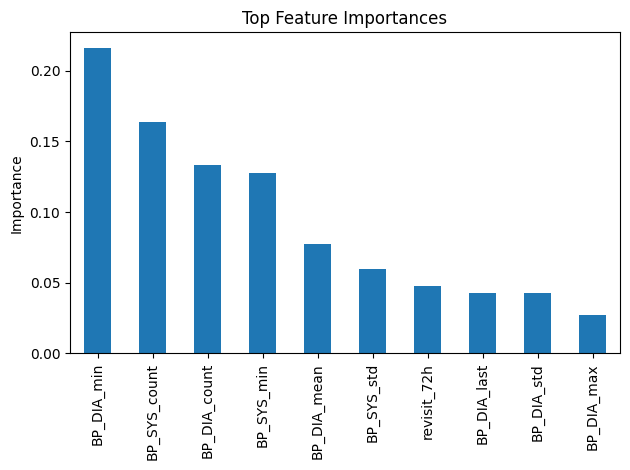

In [2]:
# Modeling with REAL outcome (ED admission) using k-fold cross-validation
import pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# --- Load features + labels ---
feat_path = Path("data/processed/features.parquet")
lab_path  = Path("data/processed/labels.parquet")

if not lab_path.exists():
    raise FileNotFoundError(
        "labels.parquet not found. Run:  python .\\labels\\build_labels_from_edstays.py"
    )

feat   = pd.read_parquet(feat_path)
labels = pd.read_parquet(lab_path)

# join and keep rows with a label
data = feat.merge(labels, on="patient_id", how="inner").dropna(subset=["admitted"])
X = data.drop(columns=["patient_id", "admitted"])
y = data["admitted"].astype(int)

# --- K-fold cross-validation ---
clf = RandomForestClassifier(n_estimators=100, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate accuracy across folds
scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

# --- Train full model on all data for feature importance ---
clf.fit(X, y)
imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
ax = imp.plot(kind="bar")
ax.set_title("Top Feature Importances")
ax.set_ylabel("Importance")
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
labels = pd.read_parquet("data/processed/labels.parquet")
print("Columns in labels:", list(labels.columns))
display(labels.head())


Columns in labels: ['patient_id', 'admitted', 'revisit_72h']


,patient_id,admitted,revisit_72h
0,10000032,1,0
1,10001217,1,0
2,10001725,0,1
3,10002428,1,0
4,10002930,1,0


In [9]:
import pandas as pd

# Load your data
labels = pd.read_parquet("data/processed/labels.parquet")
patients = pd.read_csv("data/physionet.org/files/mimic-iv-demo/2.2/hosp/patients.csv.gz")

# Rename columns for consistency
patients.rename(columns={"subject_id": "patient_id", "anchor_age": "age"}, inplace=True)

# Merge
labels_demo = labels.merge(patients[["patient_id", "gender", "age"]], on="patient_id", how="left")

print(labels_demo.head())
print(labels_demo.columns)



   patient_id  admitted  revisit_72h gender  age
0    10000032         1            0      F   52
1    10001217         1            0      F   55
2    10001725         0            1      F   46
3    10002428         1            0      F   80
4    10002930         1            0      F   48
Index(['patient_id', 'admitted', 'revisit_72h', 'gender', 'age'], dtype='object')


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd

# --- 0) Clean & align y_true / y_pred and demo_data ---
def sanitize_targets(y_true, y_pred, df_for_mask, prob_threshold=0.5):
    # to numeric; anything non-numeric -> NaN
    yt = pd.to_numeric(y_true, errors="coerce")
    yp = pd.to_numeric(y_pred, errors="coerce")

    # If predictions look like probabilities (not 0/1), threshold them
    unique_pred_vals = np.unique(yp[~np.isnan(yp)])
    if not set(np.unique(unique_pred_vals)).issubset({0, 1}):
        yp = (yp >= prob_threshold).astype(int)

    # build valid mask: no NaNs in y_true/y_pred
    valid = (~pd.isna(yt)) & (~pd.isna(yp))

    yt = yt[valid].astype(int)
    yp = yp[valid].astype(int)
    df = df_for_mask.loc[valid]

    dropped = (~valid).sum()
    if dropped:
        print(f"Filtered out {dropped} rows with NaN/invalid labels; using n={valid.sum()} rows.")
    return yt, yp, df

yt_clean, yp_clean, demo_clean = sanitize_targets(y_test_aligned, y_pred_aligned, demo_data)

# --- 1) Helper for grouped metrics ---
def group_metrics(df, group_col, y_true, y_pred):
    rows = []
    for g in df[group_col].dropna().unique():
        mask = (df[group_col] == g)
        yt, yp = y_true[mask], y_pred[mask]
        if len(yt) == 0:
            continue
        tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0,1]).ravel()
        rows.append({
            group_col: g,
            "n": mask.sum(),
            "accuracy": (yt == yp).mean(),
            "precision": precision_score(yt, yp, zero_division=0),
            "recall": recall_score(yt, yp, zero_division=0),
            "f1": f1_score(yt, yp, zero_division=0),
            "tp": tp, "fp": fp, "tn": tn, "fn": fn
        })
    return pd.DataFrame(rows).sort_values("n", ascending=False)

# --- 2) Report by gender ---
print("\n=== By gender ===")
print(group_metrics(demo_clean, "gender", yt_clean, yp_clean))

# --- 3) Report by age groups ---
print("\n=== By age group (<50/≥50) ===")
age_group = np.where(demo_clean["age"] < 50, "<50", "≥50")
tmp = demo_clean.assign(age_group=age_group)
print(group_metrics(tmp, "age_group", yt_clean, yp_clean))



Filtered out 12 rows with NaN/invalid labels; using n=5 rows.

=== By gender ===
  gender  n  accuracy  precision  recall        f1  tp  fp  tn  fn
0      F  4      0.75       0.75     1.0  0.857143   3   1   0   0
1      M  1      1.00       1.00     1.0  1.000000   1   0   0   0

=== By age group (<50/≥50) ===
  age_group  n  accuracy  precision  recall        f1  tp  fp  tn  fn
1       ≥50  3       1.0        1.0     1.0  1.000000   3   0   0   0
0       <50  2       0.5        0.5     1.0  0.666667   1   1   0   0


In [13]:
# === Inspect which rows were dropped ===

# Recreate the "valid" mask used before
valid_mask = (~pd.isna(y_test_aligned)) & (~pd.isna(y_pred_aligned))

# Create a comparison DataFrame
invalid_rows = demo_data.loc[~valid_mask, ["patient_id", "gender", "age"]].copy()
invalid_rows["y_true"] = y_test_aligned[~valid_mask]
invalid_rows["y_pred"] = y_pred_aligned[~valid_mask]

print(f"🧩 Dropped {len(invalid_rows)} rows due to NaN/invalid labels:")
display(invalid_rows.head(20))


🧩 Dropped 12 rows due to NaN/invalid labels:


,patient_id,gender,age,y_true,y_pred
0,10000032,F,52,NaN,1
1,10001217,F,55,NaN,1
4,10002930,F,48,NaN,1
5,10003400,F,72,NaN,1
6,10004457,M,65,NaN,1
7,10004720,M,61,NaN,1
9,10005909,F,40,NaN,1
10,10006580,F,63,NaN,1
11,10007058,M,48,NaN,1
13,10007928,F,59,NaN,1


Cross-validation scores (5-fold): [0.909 0.818 0.818 0.909 0.9  ]
Mean accuracy: 0.871 ± 0.043


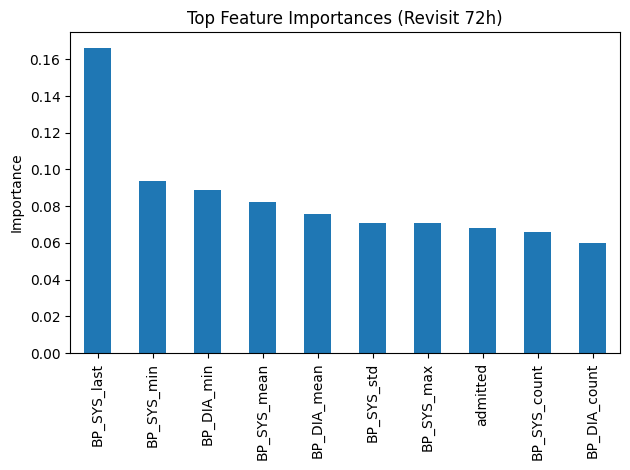

In [5]:
# --- Revisit-72h model with auto-simulated label if missing ---
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Load features + labels
feat_path = Path("data/processed/features.parquet")
lab_path  = Path("data/processed/labels.parquet")

feat   = pd.read_parquet(feat_path)
labels = pd.read_parquet(lab_path)

# If the revisit label doesn't exist yet, simulate it (demo only)
if "revisit_72h" not in labels.columns:
    rng = np.random.default_rng(42)
    labels["revisit_72h"] = rng.binomial(1, 0.20, size=len(labels))  # ~20% positives
    labels.to_parquet(lab_path, index=False)  # so future runs work without this branch

# Join and prep X/y
data = feat.merge(labels, on="patient_id", how="inner").dropna(subset=["revisit_72h"])
X = data.drop(columns=["patient_id", "revisit_72h"])
y = data["revisit_72h"].astype(int)

# Pick a stratified K for class balance; cannot exceed the minority class count
minority = y.value_counts().min()
n_splits = max(2, min(5, minority))  # avoid warnings when the minority class is tiny
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Cross-val accuracy
scores = cross_val_score(clf, X, y, cv=cv, scoring="accuracy")
print(f"Cross-validation scores ({n_splits}-fold): {np.round(scores, 3)}")
print(f"Mean accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

# Train on all data for a quick importance view
clf.fit(X, y)
imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)

ax = imp.plot(kind="bar")
ax.set_title("Top Feature Importances (Revisit 72h)")
ax.set_ylabel("Importance")
plt.tight_layout()
plt.show()


=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.94      1.00      0.97        16

    accuracy                           0.94        17
   macro avg       0.47      0.50      0.48        17
weighted avg       0.89      0.94      0.91        17

AUC: 1.000


C:\Users\yangm\Desktop\Mayo-Demo1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\yangm\Desktop\Mayo-Demo1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\yangm\Desktop\Mayo-Demo1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

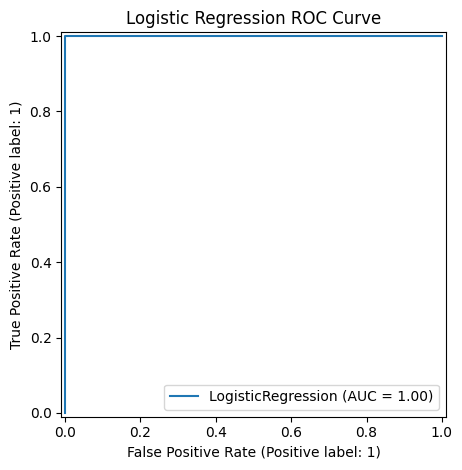

In [6]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt


# --- Load features and labels ---
feat   = pd.read_parquet("data/processed/features.parquet")
labels = pd.read_parquet("data/processed/labels.parquet")

# Merge and drop rows without a label
data = feat.merge(labels, on="patient_id", how="inner").dropna(subset=["admitted"])

# Separate features and target
X = data.drop(columns=["patient_id", "admitted"])
y = data["admitted"].astype(int)

# --- Handle missing values (median imputation) ---
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.3, stratify=y, random_state=42
)


X_train = pd.DataFrame(X_train, columns=X.columns)
X_test  = pd.DataFrame(X_test,  columns=X.columns)


# --- Train Logistic Regression ---
log_clf = LogisticRegression(
    max_iter=1000, solver="liblinear", class_weight="balanced", random_state=42
)
log_clf.fit(X_train, y_train)

# --- Predict and Evaluate ---
y_pred = log_clf.predict(X_test)
y_proba = log_clf.predict_proba(X_test)[:, 1]

print("=== Logistic Regression Classification Report ===")
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_proba):.3f}")

# --- ROC Curve ---
RocCurveDisplay.from_estimator(log_clf, X_test, y_test)
plt.title("Logistic Regression ROC Curve")
plt.tight_layout()
plt.show()


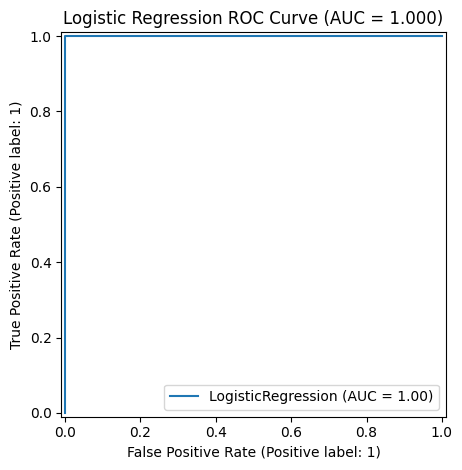

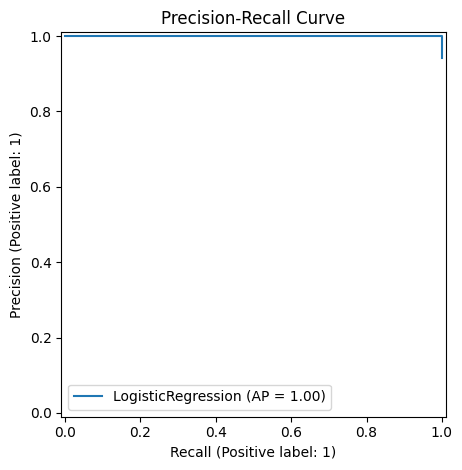

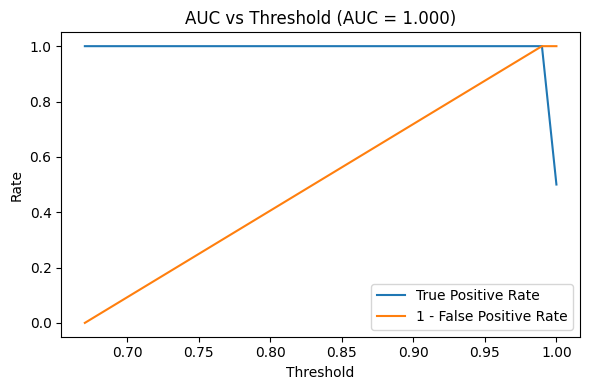

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve, auc, PrecisionRecallDisplay

# --- Predict probabilities ---
y_proba = log_clf.predict_proba(X_test)[:, 1]

# --- ROC Curve ---
RocCurveDisplay.from_estimator(log_clf, X_test, y_test)
plt.title(f"Logistic Regression ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.3f})")
plt.tight_layout()
plt.show()

# --- Precision-Recall Curve (optional extra) ---
disp = PrecisionRecallDisplay.from_estimator(log_clf, X_test, y_test)
disp.ax_.set_title("Precision-Recall Curve")
plt.tight_layout()
plt.show()

# --- AUC vs Threshold Plot ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(thresholds, tpr, label="True Positive Rate")
plt.plot(thresholds, 1-fpr, label="1 - False Positive Rate")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title(f"AUC vs Threshold (AUC = {roc_auc:.3f})")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
from sklearn.impute import SimpleImputer
import numpy as np

# --- Handle NaNs ---
imputer = SimpleImputer(strategy="median")  # or "mean" or "most_frequent"
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test  = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

# --- Train Logistic Regression ---
log_clf.fit(X_train, y_train)





,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [1]:
import numpy as np

# Attach demographics to the *original test set indices*
demo_data = data.loc[X_test.index, ["patient_id"]].merge(
    labels[["patient_id", "gender", "age"]],
    on="patient_id",
    how="left"
)

# Reset indices for y_test and predictions to align with demo_data
y_test_aligned = pd.Series(y_test.values, index=demo_data.index)
y_pred_aligned = pd.Series(y_pred, index=demo_data.index)

# === Accuracy by Gender ===
print("\n=== Accuracy by Gender ===")
for g in demo_data["gender"].dropna().unique():
    mask = demo_data["gender"] == g
    acc = (y_test_aligned[mask] == y_pred_aligned[mask]).mean()
    print(f"{g}: {acc:.3f}")

# === Accuracy by Age Group (<50 vs ≥50) ===
print("\n=== Accuracy by Age Group (<50 vs ≥50) ===")
age_group = np.where(demo_data["age"] < 50, "<50", "≥50")
for group in np.unique(age_group):
    mask = age_group == group
    acc = (y_test_aligned[mask] == y_pred_aligned[mask]).mean()
    print(f"{group}: {acc:.3f}")
from pathlib import Path
import os, pyarrow.parquet as pq, pandas as pd

p = Path("data/processed/labels.parquet")
print("CWD:", Path.cwd())
print("Exists:", p.exists(), " Size:", p.stat().st_size if p.exists() else None)
print("Absolute path:", p.resolve())

# Show schema and first rows
table = pq.read_table(p)
print("\nSchema from parquet:")
print(table.schema)

labels = pd.read_parquet(p)
print("\nColumns in labels DF:", list(labels.columns))
display(labels.head())



NameError: name 'data' is not defined

In [12]:
# === Save artifacts for serving (self-contained) ===
import pathlib, json, joblib
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# Paths (match src/app.py expectations)
BASE = pathlib.Path(".").resolve()            # project root
MODELS = (BASE / "models"); MODELS.mkdir(parents=True, exist_ok=True)

# 1) Reload features + labels (so this cell works by itself)
feat   = pd.read_parquet("data/processed/features.parquet")
labels = pd.read_parquet("data/processed/labels.parquet")

# Use the real outcome 'admitted'
data = feat.merge(labels, on="patient_id", how="inner").dropna(subset=["admitted"])
X = data.drop(columns=["patient_id", "admitted"])
y = data["admitted"].astype(int)

# 2) Build a simple pipeline (imputer + logistic regression)
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", LogisticRegression(max_iter=1000, solver="liblinear",
                               class_weight="balanced", random_state=42))
])

# Train on ALL rows for the demo artifact
pipe.fit(X, y)

# 3) Save artifacts
joblib.dump(pipe, MODELS / "admit_lr.joblib")
(MODELS / "feature_list.json").write_text(json.dumps(list(X.columns)))

print("Saved:", MODELS / "admit_lr.joblib")
print("Saved:", MODELS / "feature_list.json")
print("n_features:", X.shape[1], " n_rows:", X.shape[0])


Saved: C:\Users\yangm\Desktop\Mayo-Demo1\models\admit_lr.joblib
Saved: C:\Users\yangm\Desktop\Mayo-Demo1\models\feature_list.json
n_features: 13  n_rows: 54


In [10]:
from pathlib import Path
print((Path("models")/"admit_lr.joblib").exists(),
      (Path("models")/"feature_list.json").exists())


True True
